In [60]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse ,  Sequence , Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist , squareform

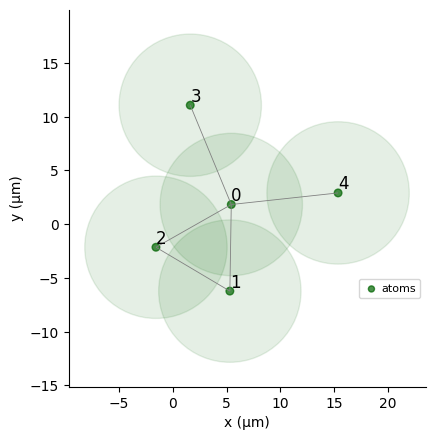

In [61]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)


def evaluate_mapping(new_coords , Q):
    """Cost function to minimize. Ideally , the pairwise distance are conserved."""
    new_coords = np.reshape(new_coords , (len(Q) , 2))
    # computing the matrix of the distance between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff/ pdist(new_coords)**6
    )
    return np.linalg.norm(new_Q - Q)


costs = []
np.random.seed(0)
x0 = np.random.random(len(Q)*2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    #method = "COBYLA",
    tol = 1e-6,
     options={"maxiter":2000000, "maxfev":None}
)

coords = np.reshape(res.x , (len(Q) , 2))


qubits = dict(enumerate(coords))
reg = Register(qubits=qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph= True,
    draw_half_radius=True)

In [62]:
# just a customize ploting
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

3.13810197


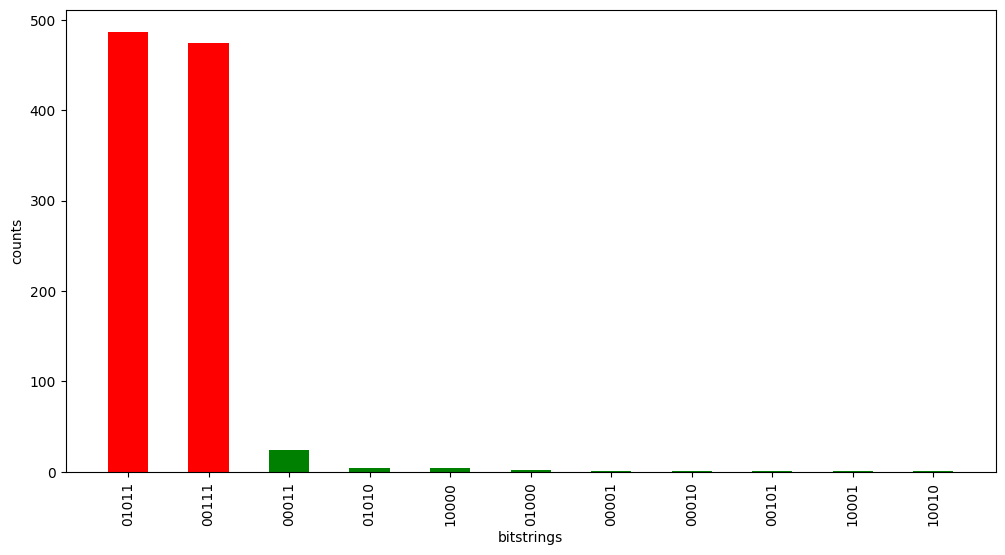

In [63]:
import matplotlib.pyplot as plt

# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
print(Omega)
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system



adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
#seq.draw()


simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

plot_distribution(count_dict)

In [64]:
cost = []

def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples


for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

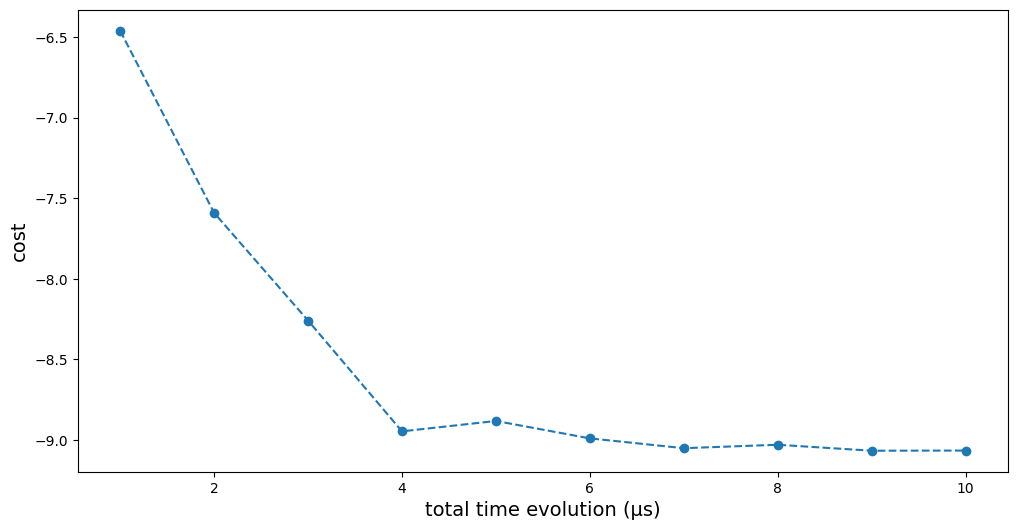

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

In [66]:
# def cost_function(Omega, delta_0 , time_evol):
#     adiabatic_pulse = Pulse(
#         InterpolatedWaveform(time_evol, [1e-9, Omega, 1e-9]),
#         InterpolatedWaveform(time_evol, [delta_0, 0, -delta_0]),
#         0,
#     )
def cost_function(Omega, delta_0 ):
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, -delta_0]),
        0,
    )
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    count_dict = results.sample_final_state()
    
    # Calculate the cost function for each observed state
    cost = 0
    for state, prob in count_dict.items():
        z = np.array([int(bit) for bit in state])  # convert the state into a binary vector
        cost += prob * z.T @ Q @ z
    return cost

Optimized Omega: 2.100026407885817, Optimized delta_0: -5.472542636652276


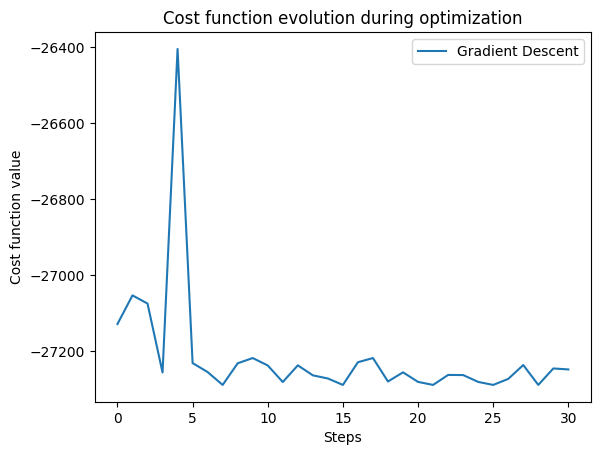

In [67]:
from scipy.optimize import minimize

cost_values = []
# Optimization function for `minimize`
def optimization_function(params):
    Omega, delta_0 = params
    #Omega, delta_0 , time_evol = params

    #cost = cost_function(Omega, delta_0, time_evol)
    cost = cost_function(Omega, delta_0)

    cost_values.append(cost)
    return cost

# Parameter initialization
# initial_guess = [Omega, delta_0, T]
initial_guess = [Omega, delta_0]
#result = minimize(optimization_function, initial_guess, method='Nelder-Mead')
result = minimize(optimization_function, initial_guess, method='Cobyla')

#optimized_Omega, optimized_delta_0, optimized_time_evol = result.x
optimized_Omega, optimized_delta_0 = result.x
print(f"Optimized Omega: {optimized_Omega}, Optimized delta_0: {optimized_delta_0}")

# Plotting the gradient descent
plt.plot(cost_values, label="Gradient Descent")
plt.xlabel("Steps")
plt.ylabel("Cost function value")
plt.title("Cost function evolution during optimization")
plt.legend()
plt.show()

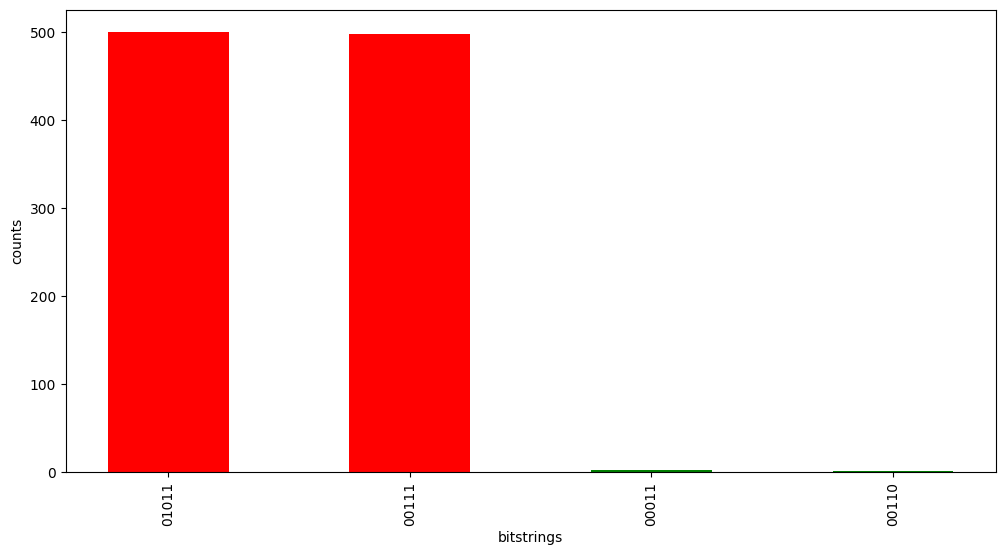

In [68]:
# Final simulation with optimized parameters
adiabatic_pulse_optimal = Pulse(
    InterpolatedWaveform(T, [1e-9, optimized_Omega, 1e-9]),
    InterpolatedWaveform(T, [optimized_delta_0, 0, -optimized_delta_0]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse_optimal, "ising")
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
count_dict_optimal = results.sample_final_state()

plot_distribution(count_dict_optimal)

In [69]:
print(count_dict_optimal)
print(count_dict)

Counter({'01011': 500, '00111': 497, '00011': 2, '00110': 1})
Counter({'01011': 509, '00111': 481, '01001': 3, '00011': 2, '00101': 2, '00110': 1, '01010': 1, '10010': 1})


In [77]:
import numpy as np
import matplotlib.pyplot as plt

num_cities = 10
np.random.seed(0)
city_locations = np.random.rand(num_cities, 2) * 100
city_populations = np.random.randint(1000, 5000, size=num_cities)

def generate_antenna_positions(city_locations, radius):
    positions = []
    for loc in city_locations:
        x, y = loc
        for dx in np.arange(-radius, radius + 1, radius):
            for dy in np.arange(-radius, radius + 1, radius):
                if dx**2 + dy**2 <= radius**2:
                    positions.append((x + dx, y + dy))
    return np.array(positions)

def calculate_coverage(antenna_positions, city_locations, city_populations, coverage_percentage=0.7):
    covered_cities = []
    for i, city in enumerate(city_locations):
        population = city_populations[i]
        coverage_needed = population * coverage_percentage
        distances = np.linalg.norm(antenna_positions - city, axis=1)
        covered_population = np.sum(population * (distances <= 25))
        if covered_population >= coverage_needed:
            covered_cities.append(i)
    return covered_cities

def generate_waveform_col


SyntaxError: invalid syntax (224854678.py, line 30)